In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

In [2]:
def compute_global_mean(ds):
    wts = ds.profile_weight/ds.profile_weight.sum()
    return(ds.weighted(wts).mean(["site"]))

In [3]:
#copy directory here
os.chdir('/Users/emmalayton/Desktop/senior_thesis/RFMIP-IRF_intake_catalogue')

In [4]:
from intake import open_catalog
cat = open_catalog(os.getcwd() + '/main.yml')

In [5]:
extrainfo = xr.open_dataset(os.getcwd() + '/multiple_input4MIPs_radiation_RFMIP_UColorado-RFMIP-1-2_none.nc').to_dataframe()

pseudocode:
start with global mean
(error[perturbation experiment]-error[present day])/concentration[perturbation experiment]-concentration[present day]


In [75]:
benchmark = xr.concat([compute_global_mean(cat.benchmark.LBLRTM.p1f1[f].to_dask()) 
                               for f in ["rlu", "rld", "rsu", "rsd"]], 
                               dim="field", data_vars = "different")
benchmark = benchmark.assign_coords(expt=extrainfo['expt_label'].unique())

/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [80]:
#RRTMG scaling
#find the scaling factor at the boundary (top of atmosphere)
rrtmg_p1f1_scale = cat.benchmark.LBLRTM.p1f1.rsd.to_dask().rsd.isel(level=0)/cat.parameterized.RRTMG.p1f1.rsd.to_dask().rsd.isel(level=0)
#concatenate the RRTMG data
adjusted_rrtmg = xr.concat([cat.parameterized.RRTMG.p1f1[f].to_dask()
                for f in ["rlu","rld", "rsd","rsu"]],
                dim="field", data_vars = "different")
#scale all of the shortwave data by the scaling factor
for f in ['rsd','rsu']:
    adjusted_rrtmg = adjusted_rrtmg.update({f: rrtmg_p1f1_scale*adjusted_rrtmg[f]})

/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/co

In [82]:
gbms = {}
for m in list(cat.parameterized):
    print("Trying model ", m)
    for r in list(cat.parameterized[m]):
        print(" Realization ", r)
        #use the scaled RRTMG dataset
        if "RRTMG" in m and "RTE_RRTMGP" not in m:
            gbms[f'{m}_{r}'] = xr.concat([compute_global_mean(adjusted_rrtmg) 
                                         for x in ["rlu","rld", "rsd","rsu"]], 
                                         dim="field", data_vars = "different")
        else:
            gbms[f'{m}_{r}'] = xr.concat([compute_global_mean(cat.parameterized[m][r][f].to_dask()) 
                            for f in ["rlu","rld","rsu","rsd"]], 
                            dim="field", data_vars = "different")
        
gbms = {k: gbms[k].assign_coords(expt=extrainfo['expt_label'].unique()) for k in gbms.keys()}

Trying model  CanESM5
 Realization  p2f2
Trying model  GISS_E2
 Realization  p1f1
Trying model  GISS_E3
 Realization  p1f1
Trying model  HadGEM3
 Realization  p1f2


/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/co

 Realization  p1f3


/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Trying model  MIROC6
 Realization  p1f1
Trying model  GFDL
 Realization  p1f2
Trying model  RRTMG
 Realization  p1f1
Trying model  RTE_RRTMGP
 Realization  p1f1


/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [72]:
#test to make sure i scaled the top of atmosphere for RRTMG_p1f1 correctly
x = cat.benchmark.LBLRTM.p1f1.rsd.to_dask()
(adjusted_rrtmg.isel(level=0).rsd-x.isel(level=0).rsd).max()

<xarray.DataArray 'rsd' ()>
array(6.1035156e-05, dtype=float32)

In [83]:
gbms["RRTMG_p1f1"]
#the gbm average values for rsd are approximately double what they should be

<xarray.Dataset>
Dimensions:         (expt: 18, level: 61)
Coordinates:
  * expt            (expt) object 'Present day (PD)' ... 'LGM'
Dimensions without coordinates: level
Data variables:
    rld             (expt, level) float32 0.0 0.2315 0.4441 ... 310.5 311.9
    rsd             (expt, level) float32 646.9 647.5 648.3 ... 881.2 881.4
    rsu             (expt, level) float32 78.42 78.49 78.59 ... 128.9 128.9
    plev            (level) float32 0.01 20.0 38.43 ... 9.839e+04 9.862e+04
    rlu             (expt, level) float32 264.4 264.5 264.5 ... 395.6 397.8
    profile_weight  float64 0.01053

In [16]:
#calculate benchmark lw and sw flux
benchmark = benchmark.assign(rln=benchmark.data_vars['rld']-benchmark.data_vars['rlu'])
benchmark = benchmark.assign(rsn=benchmark.data_vars['rsd']-benchmark.data_vars['rsu'])
#calculate parameterized lw and sw flux
gbms = {k: gbms[k].assign(rln=gbms[k].data_vars['rld']-gbms[k].data_vars['rlu']) for k in gbms.keys()}
gbms = {k: gbms[k].assign(rsn=gbms[k].data_vars['rsd']-gbms[k].data_vars['rsu']) for k in gbms.keys()}

In [17]:
gbmforcing = gbms.copy()
for m in list(gbms.keys()):
    gbmforcing[m] = gbmforcing[m] - gbmforcing[m].isel(expt=0)

In [18]:
gbmforcing_b = benchmark.copy()
gbmforcing_b = gbmforcing_b - gbmforcing_b.isel(expt=0)

In [19]:
gbme = {k: (gbmforcing[k]-gbmforcing_b) for k in gbmforcing.keys()}

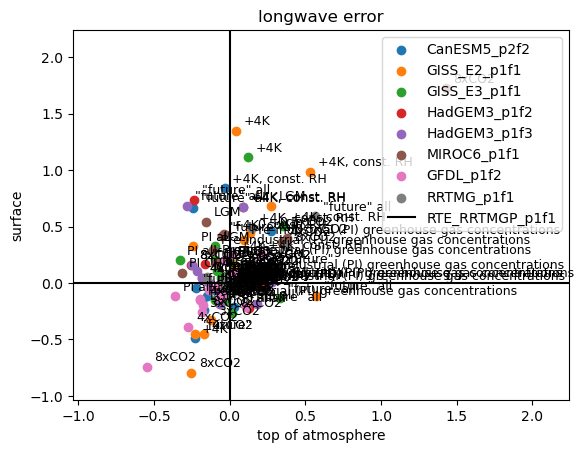

In [20]:
fig, ax = plt.subplots()
squaremax = 0
squaremin = 0
for m in list(gbme.keys()):
    if "RRTMG_p1f1" not in m:
        plt.scatter(gbme[m].data_vars["rln"][:,0],gbme[m].data_vars["rln"][:,60]) 
        for i in range(len(gbme[m].expt)):
            plt.text(gbme[m].data_vars["rln"][i,0]+0.05,gbme[m].data_vars["rln"][i,60]+0.05, gbme[m].expt[i].values, fontsize=9)
        newmax = np.concatenate((gbme[m].data_vars["rln"][:,0],gbme[m].data_vars["rln"][:,60])).max()
        newmin = np.concatenate((gbme[m].data_vars["rln"][:,0],gbme[m].data_vars["rln"][:,60])).min()
        if newmax>squaremax:
            squaremax = newmax
        if newmin<squaremin:
            squaremin = newmin

plt.xlim(1.3*squaremin,1.3*squaremax)
plt.ylim(1.3*squaremin,1.3*squaremax)
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("longwave error")
plt.show()

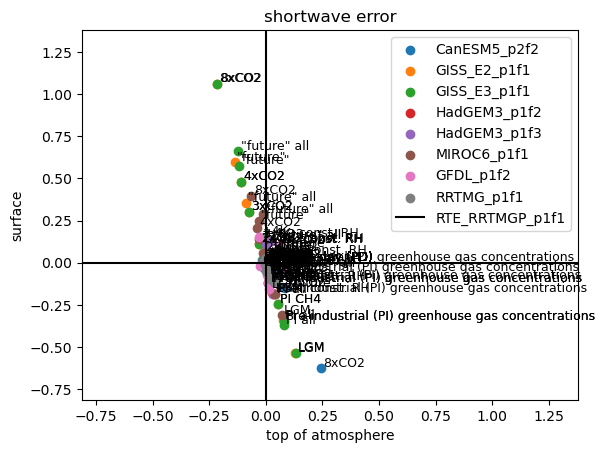

In [21]:
fig1, ax1 = plt.subplots()
squaremax = 0
squaremin = 0
for m in list(gbme.keys()):
    if "RRTMG_p1f1" not in m:
        plt.scatter(gbme[m].data_vars["rsn"][:,0],gbme[m].data_vars["rsn"][:,60])
        for i in range(len(gbme[m].expt)):
            plt.text(gbme[m].data_vars["rsn"][i,0]+0.01,gbme[m].data_vars["rsn"][i,60]+0.01, gbme[m].expt[i].values, fontsize=9) 
        newmax = np.concatenate((gbme[m].data_vars["rsn"][:,0],gbme[m].data_vars["rsn"][:,60])).max()
        newmin = np.concatenate((gbme[m].data_vars["rsn"][:,0],gbme[m].data_vars["rsn"][:,60])).min()
        if newmax>squaremax:
            squaremax = newmax
        if newmin<squaremin:
            squaremin = newmin

plt.xlim(1.3*squaremin,1.3*squaremax)
plt.ylim(1.3*squaremin,1.3*squaremax)
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("shortwave error")
plt.show()

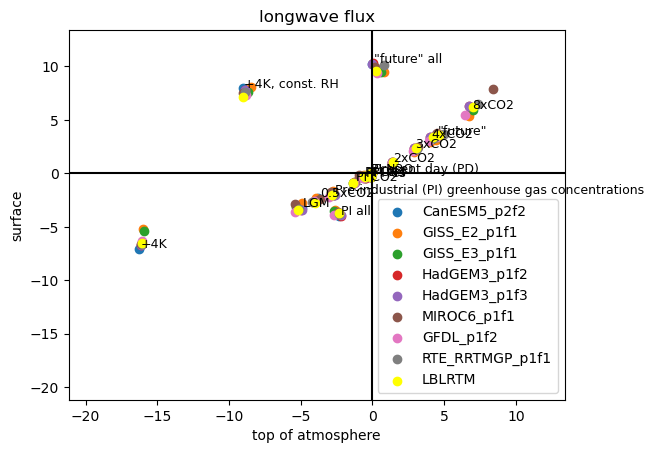

In [22]:
fig, ax = plt.subplots()
squaremax = 0
squaremin = 0
legend = list(gbmforcing.keys())
legend.append("LBLRTM")
for m in list(gbmforcing.keys()):
    if "RRTMG_p1f1" not in m:
        plt.scatter(gbmforcing[m]["rln"][:,0],gbmforcing[m]["rln"][:,60])
        if "CanESM5_p2f2" in m:
            for i in range(len(gbme[m].expt)):
                plt.text(gbmforcing[m].data_vars["rln"][i,0]+0.1,gbmforcing[m].data_vars["rln"][i,60]+0.1, gbmforcing[m].expt[i].values, fontsize=9) 
        #plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
        newmax = np.concatenate((gbmforcing[m].data_vars["rln"][:,0],gbmforcing[m].data_vars["rln"][:,60])).max()
        newmin = np.concatenate((gbmforcing[m].data_vars["rln"][:,0],gbmforcing[m].data_vars["rln"][:,60])).min()
        if newmax>squaremax:
            squaremax = newmax
        if newmin<squaremin:
            squaremin = newmin

plt.xlim(1.3*squaremin,1.3*squaremax)
plt.ylim(1.3*squaremin,1.3*squaremax)
plt.scatter(gbmforcing_b["rln"][:,0],gbmforcing_b["rln"][:,60], color='yellow')

plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend([k for k in legend if "RRTMG_p1f1" not in k])
plt.title("longwave flux")
plt.show()

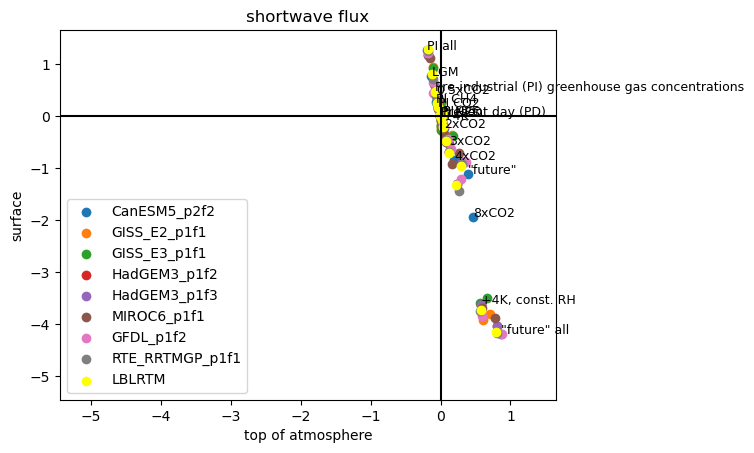

In [23]:
fig, ax = plt.subplots()
squaremax = 0
squaremin = 0
for m in list(gbmforcing.keys()):
    if "RRTMG_p1f1" not in m:
        plt.scatter(gbmforcing[m]["rsn"][:,0],gbmforcing[m]["rsn"][:,60])
        if "CanESM5_p2f2" in m:
            for i in range(len(gbmforcing[m].expt)):
                plt.text(gbmforcing[m].data_vars["rsn"][i,0],gbmforcing[m].data_vars["rsn"][i,60], gbmforcing[m].expt[i].values, fontsize=9)
        newmax = np.concatenate((gbmforcing[m].data_vars["rsn"][:,0],gbmforcing[m].data_vars["rsn"][:,60])).max()
        newmin = np.concatenate((gbmforcing[m].data_vars["rsn"][:,0],gbmforcing[m].data_vars["rsn"][:,60])).min()
        if newmax>squaremax:
            squaremax = newmax
        if newmin<squaremin:
            squaremin = newmin

plt.xlim(1.3*squaremin,1.3*squaremax)
plt.ylim(1.3*squaremin,1.3*squaremax)
plt.scatter(gbmforcing_b["rsn"][:,0],gbmforcing_b["rsn"][:,60], color='yellow')
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend([k for k in legend if "RRTMG_p1f1" not in k])
plt.title("shortwave flux")
plt.show()

<xarray.DataArray 'rsd' (expt: 18)>
array([335.18933, 335.18933, 335.18933, 335.18933, 335.18933, 335.18933,
       335.18933, 335.18933, 335.18933, 335.18933, 335.18933, 335.18933,
       335.18933, 335.18933, 335.18933, 335.18933, 335.18933, 335.18933],
      dtype=float32)
Coordinates:
  * expt     (expt) object 'Present day (PD)' ... 'LGM' <xarray.DataArray 'rsd' (expt: 18)>
array([335.18933, 335.18933, 335.18933, 335.18933, 335.18933, 335.18933,
       335.18933, 335.18933, 335.18933, 335.18933, 335.18933, 335.18933,
       335.18933, 335.18933, 335.18933, 335.18933, 335.18933, 335.18933],
      dtype=float32)
Coordinates:
  * expt     (expt) object 'Present day (PD)' ... 'LGM'
<xarray.DataArray 'rsd' (expt: 18)>
array([335.1892, 335.1892, 335.1892, 335.1892, 335.1892, 335.1892,
       335.1892, 335.1892, 335.1892, 335.1892, 335.1892, 335.1892,
       335.1892, 335.1892, 335.1892, 335.1892, 335.1892, 335.1892],
      dtype=float32)
Coordinates:
  * expt     (expt) object 'Present 

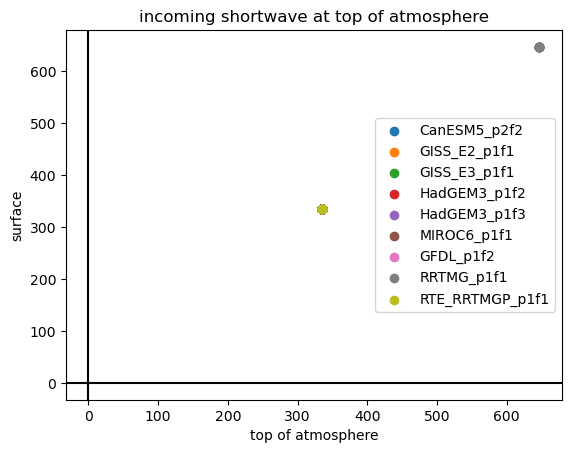

In [24]:
fig, ax = plt.subplots()
for m in list(gbms.keys()):
    plt.scatter(gbms[m].data_vars["rsd"][:,0],gbms[m].data_vars["rsd"][:,0])
    print(gbms[m].data_vars["rsd"][:,0],gbms[m].data_vars["rsd"][:,0])
'''
    if "RRTMG_p1f1" in m:
        for i in range(len(gbme[m].expt)):
            plt.text(gbme[m].data_vars["rln"][i,0]+0.1,gbme[m].data_vars["rln"][i,1]+0.1, gbme[m].expt[i].values, fontsize=9) 
'''
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("incoming shortwave at top of atmosphere")
plt.show()

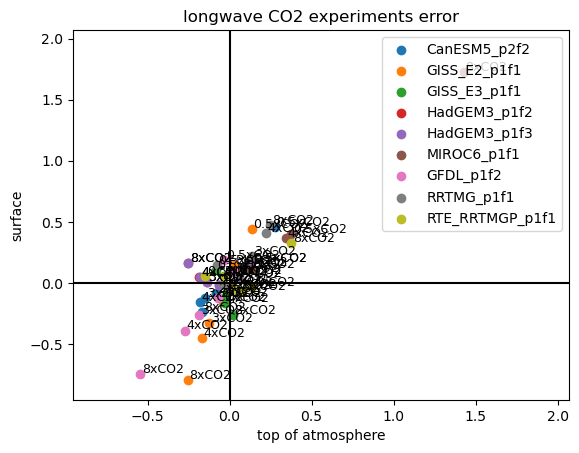

In [25]:
fig, ax = plt.subplots()
selected_experiments = ['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']
squaremax = 0
squaremin = 0
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rln"][:,0].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']),gbme[m].data_vars["rln"][:,60].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']))
    newmax = np.concatenate((gbme[m].data_vars["rln"][:,0].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']), gbme[m].data_vars["rln"][:,60].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']))).max()
    newmin = np.concatenate((gbme[m].data_vars["rln"][:,0].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']), gbme[m].data_vars["rln"][:,60].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']))).min()
    if newmax>squaremax:
        squaremax = newmax
    if newmin<squaremin:
        squaremin = newmin
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text(gbme[m].data_vars["rln"][i,0]+0.01,gbme[m].data_vars["rln"][i,60]+0.01, gbme[m].expt[i].values, fontsize=9)


plt.xlim(1.2*squaremin,1.2*squaremax)
plt.ylim(1.2*squaremin,1.2*squaremax)    
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("longwave CO2 experiments error")
plt.show()

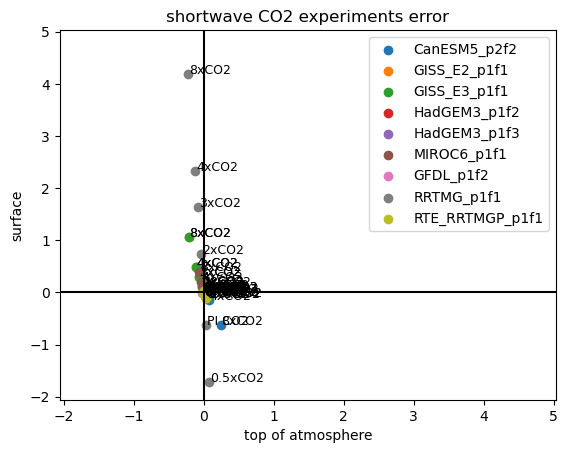

In [26]:
fig, ax = plt.subplots()
squaremax = 0
squaremin = 0
selected_experiments = ['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rsn"][:,0].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']),gbme[m].data_vars["rsn"][:,60].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']))
    newmax = np.concatenate((gbme[m].data_vars["rsn"][:,0].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']), gbme[m].data_vars["rsn"][:,60].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']))).max()
    newmin = np.concatenate((gbme[m].data_vars["rsn"][:,0].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']), gbme[m].data_vars["rsn"][:,60].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']))).min()
    if newmax>squaremax:
        squaremax = newmax
    if newmin<squaremin:
        squaremin = newmin
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text(gbme[m].data_vars["rsn"][i,0]+0.01,gbme[m].data_vars["rsn"][i,60]+0.01, gbme[m].expt[i].values, fontsize=9)
    #plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])

plt.xlim(1.2*squaremin,1.2*squaremax)
plt.ylim(1.2*squaremin,1.2*squaremax)     
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend([k for k in gbme.keys()])
plt.title("shortwave CO2 experiments error")
plt.show()

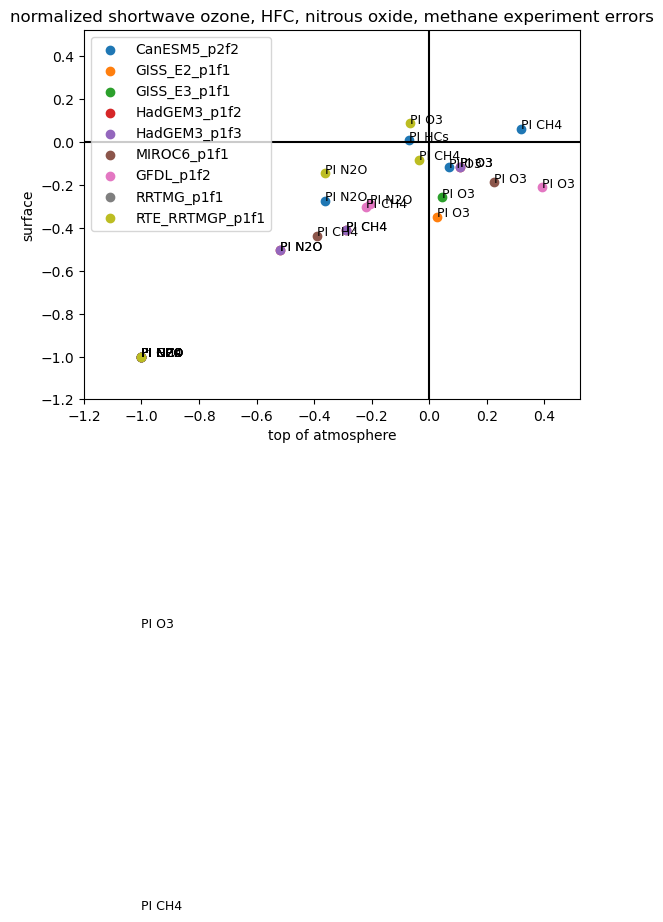

In [27]:
fig, ax = plt.subplots()
squaremax = 0
squaremin = 0
selected_experiments = [ 'PI CH4', 'PI N2O', 'PI O3', 'PI HCs']
for m in list(gbme.keys()):
    plt.scatter((gbme[m].data_vars["rsn"][:,0].sel(expt=[ 'PI CH4', 'PI N2O', 'PI O3', 'PI HCs'])/gbmforcing_b.data_vars["rsn"][:,0].sel(expt=[ 'PI CH4', 'PI N2O', 'PI O3', 'PI HCs'])),(gbme[m].data_vars["rsn"][:,60].sel(expt=[ 'PI CH4', 'PI N2O', 'PI O3', 'PI HCs'])/gbmforcing_b.data_vars["rsn"][:,60].sel(expt=[ 'PI CH4', 'PI N2O', 'PI O3', 'PI HCs'])))
    newmax = np.concatenate(((gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rsn"][:,0].sel(expt=selected_experiments)),(gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rln"][:,60].sel(expt=selected_experiments)))).max()
    newmin = np.concatenate(((gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rsn"][:,0].sel(expt=selected_experiments)),(gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rln"][:,60].sel(expt=selected_experiments)))).min()
    if newmax>squaremax:
        squaremax = newmax
    if newmin<squaremin:
        squaremin = newmin
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text((gbme[m].data_vars["rsn"][i,0]/gbmforcing_b.data_vars["rsn"][i,0]),(gbme[m].data_vars["rsn"][i,60]/gbmforcing_b.data_vars["rsn"][i,60]), gbme[m].expt[i].values, fontsize=9)
    #plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlim(1.2*squaremin,1.2*squaremax)
plt.ylim(1.2*squaremin,1.2*squaremax) 
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("normalized shortwave ozone, HFC, nitrous oxide, methane experiment errors")
plt.show()

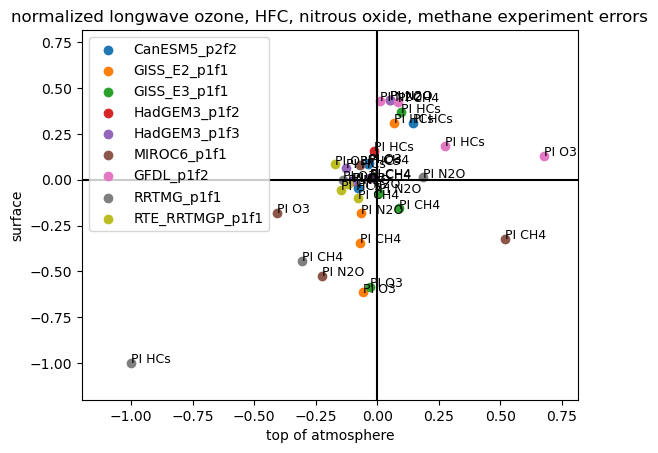

In [28]:
fig, ax = plt.subplots()
squaremax = 0
squaremin = 0
selected_experiments = [ 'PI CH4', 'PI N2O', 'PI O3', 'PI HCs']
for m in list(gbme.keys()):
    plt.scatter((gbme[m].data_vars["rln"][:,0].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rln"][:,0].sel(expt=selected_experiments)),(gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rln"][:,60].sel(expt=selected_experiments)))
    newmax = np.concatenate(((gbme[m].data_vars["rln"][:,0].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rln"][:,0].sel(expt=selected_experiments)),(gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rln"][:,60].sel(expt=selected_experiments)))).max()
    newmin = np.concatenate(((gbme[m].data_vars["rln"][:,0].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rln"][:,0].sel(expt=selected_experiments)),(gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rln"][:,60].sel(expt=selected_experiments)))).min()
    if newmax>squaremax:
        squaremax = newmax
    if newmin<squaremin:
        squaremin = newmin
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text((gbme[m].data_vars["rln"][i,0]/gbmforcing_b.data_vars["rln"][i,0]),(gbme[m].data_vars["rln"][i,60]/gbmforcing_b.data_vars["rln"][i,60]), gbme[m].expt[i].values, fontsize=9)
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlim(1.2*squaremin,1.2*squaremax)
plt.ylim(1.2*squaremin,1.2*squaremax) 
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("normalized longwave ozone, HFC, nitrous oxide, methane experiment errors")
plt.show()

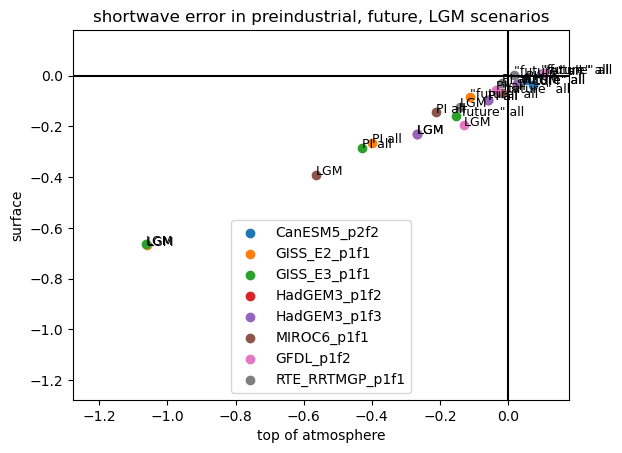

In [29]:
fig, ax = plt.subplots()
squaremax = 0
squaremin = 0
selected_experiments = [ 'PI all', '"future" all', 'LGM']
for m in list(gbme.keys()):
    if "RRTMG_p1f1" not in m:
        plt.scatter(gbme[m].data_vars["rsn"][:,0].sel(expt=[ 'PI all', '"future" all', 'LGM'])/gbmforcing_b.data_vars["rsn"][:,0].sel(expt=selected_experiments),gbme[m].data_vars["rsn"][:,60].sel(expt=[ 'PI all', '"future" all', 'LGM'])/gbmforcing_b.data_vars["rsn"][:,60].sel(expt=selected_experiments))
        newmax = np.concatenate(((gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rsn"][:,0].sel(expt=selected_experiments)),(gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rsn"][:,60].sel(expt=selected_experiments)))).max()
        newmin = np.concatenate(((gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rsn"][:,0].sel(expt=selected_experiments)),(gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rsn"][:,60].sel(expt=selected_experiments)))).min()
        if newmax>squaremax:
            squaremax = newmax
        if newmin<squaremin:
            squaremin = newmin
        for i in range(len(gbme[m].expt)):
            if gbme[m].expt[i].values in selected_experiments:
                plt.text(gbme[m].data_vars["rsn"][i,0]/gbmforcing_b.data_vars["rsn"][i,0],gbme[m].data_vars["rsn"][i,60]/gbmforcing_b.data_vars["rsn"][i,60], gbme[m].expt[i].values, fontsize=9)
    #plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlim(1.2*squaremin,1.7*squaremax)
plt.ylim(1.2*squaremin,1.7*squaremax) 
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend([k for k in gbme.keys() if "RRTMG_p1f1" not in k])
plt.title("shortwave error in preindustrial, future, LGM scenarios")
plt.show()

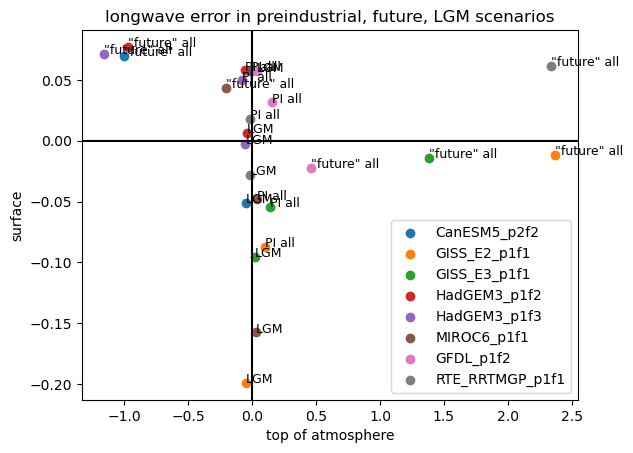

In [30]:
fig, ax = plt.subplots()
squaremax = 0
squaremin = 0
selected_experiments = [ 'PI all', '"future" all', 'LGM']
for m in list(gbme.keys()):
    if "RRTMG_p1f1" not in m:
        plt.scatter(gbme[m].data_vars["rln"][:,0].sel(expt=[ 'PI all', '"future" all', 'LGM'])/gbmforcing_b.data_vars["rln"][:,0].sel(expt=selected_experiments),gbme[m].data_vars["rln"][:,60].sel(expt=[ 'PI all', '"future" all', 'LGM'])/gbmforcing_b.data_vars["rln"][:,60].sel(expt=selected_experiments))
        newmax = np.concatenate(((gbme[m].data_vars["rln"][:,0].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rln"][:,0].sel(expt=selected_experiments)),(gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rln"][:,60].sel(expt=selected_experiments)))).max()
        newmin = np.concatenate(((gbme[m].data_vars["rln"][:,0].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rln"][:,0].sel(expt=selected_experiments)),(gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments)/gbmforcing_b.data_vars["rln"][:,60].sel(expt=selected_experiments)))).min()
        if newmax>squaremax:
            squaremax = newmax
        if newmin<squaremin:
            squaremin = newmin
        for i in range(len(gbme[m].expt)):
            if gbme[m].expt[i].values in selected_experiments:
                plt.text(gbme[m].data_vars["rln"][i,0]/gbmforcing_b.data_vars["rln"][i,0],gbme[m].data_vars["rln"][i,60]/gbmforcing_b.data_vars["rln"][i,60], gbme[m].expt[i].values, fontsize=9)
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend([k for k in gbme.keys() if "RRTMG_p1f1" not in k])
plt.title("longwave error in preindustrial, future, LGM scenarios")
plt.show()

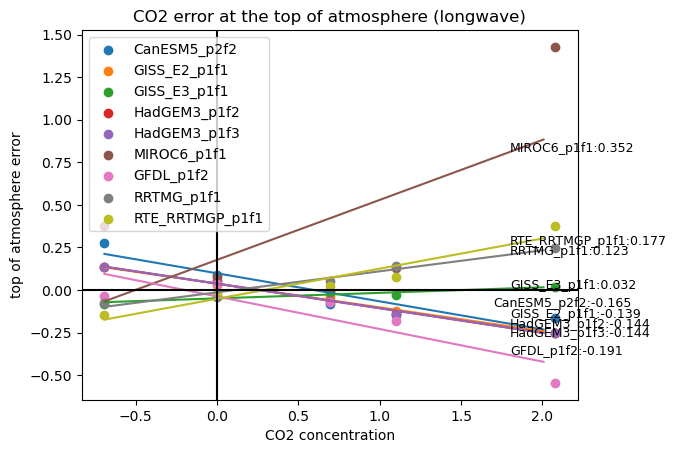

In [31]:
#vertical structure of O3
fig, ax = plt.subplots()
x = 1.8
#y = gbme[m].data_vars["rln"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'])
for m in list(gbme.keys()):
    plt.scatter(np.log([0.5, 1, 2, 3, 8]), gbme[m].data_vars["rln"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0))
plt.xlabel("CO2 concentration")
plt.legend(list(gbme.keys()))
for m in list(gbme.keys()):
    f, b = np.polyfit(np.log([0.5, 1, 2, 3, 8]), gbme[m].data_vars["rln"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0), 1)
    plt.plot(np.arange(np.log(0.5),np.log(8),0.1), np.arange(np.log(0.5),np.log(8),0.1)*f + b)
    if "CanESM5_p2f2" in m:
        plt.text(x-0.1, x*f+b+0.1, m + ":" + str('%.3f'%f), fontsize=9)
    elif "GISS_E2_p1f1" in m:
        plt.text(x, x*f+b+0.05, m + ":" + str('%.3f'%f), fontsize=9)
    elif "HadGEM3_p1f3" in m:
        plt.text(x, x*f+b-0.05, m + ":" + str('%.3f'%f), fontsize=9)
    else:
        plt.text(x, x*f+b, m + ":" + str('%.3f'%f), fontsize=9)
        
plt.ylabel("top of atmosphere error")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.title("CO2 error at the top of atmosphere (longwave)")
plt.show()
#draw straight lines through each

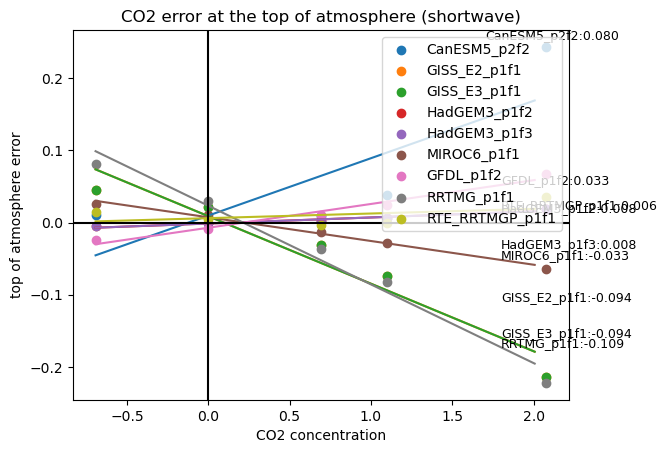

In [32]:
#vertical structure of O3
fig, ax = plt.subplots()
x = 1.8
#y = gbme[m].data_vars["rln"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'])
for m in list(gbme.keys()):
    plt.scatter(np.log([0.5, 1, 2, 3, 8]), gbme[m].data_vars["rsn"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0))
plt.xlabel("CO2 concentration")
plt.legend(list(gbme.keys()))
for m in list(gbme.keys()):
    f, b = np.polyfit(np.log([0.5, 1, 2, 3, 8]), gbme[m].data_vars["rsn"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0), 1)
    plt.plot(np.arange(np.log(0.5),np.log(8),0.1), np.arange(np.log(0.5),np.log(8),0.1)*f + b)
    if "CanESM5_p2f2" in m:
        plt.text(x-0.1, x*f+b+0.1, m + ":" + str('%.3f'%f), fontsize=9)
    elif "GISS_E2_p1f1" in m:
        plt.text(x, x*f+b+0.05, m + ":" + str('%.3f'%f), fontsize=9)
    elif "HadGEM3_p1f3" in m:
        plt.text(x, x*f+b-0.05, m + ":" + str('%.3f'%f), fontsize=9)
    else:
        plt.text(x, x*f+b, m + ":" + str('%.3f'%f), fontsize=9)
        
plt.ylabel("top of atmosphere error")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.title("CO2 error at the top of atmosphere (shortwave)")
plt.show()
#draw straight lines through each

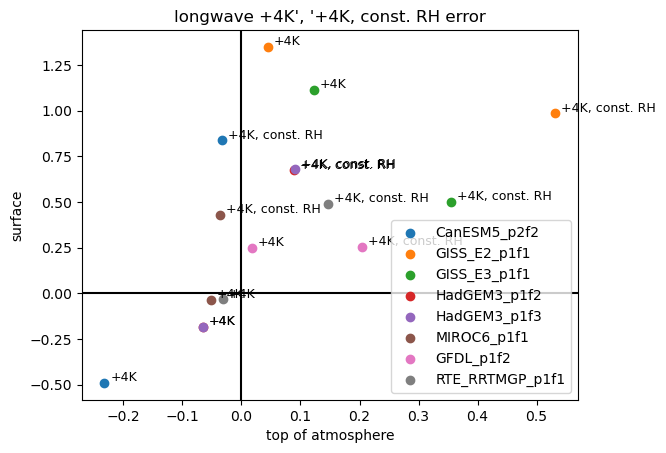

In [33]:
fig, ax = plt.subplots()
selected_experiments = ['+4K', '+4K, const. RH']

for m in list(gbme.keys()):
    if "RRTMG_p1f1" not in m:
        plt.scatter(gbme[m].data_vars["rln"][:,0].sel(expt=['+4K', '+4K, const. RH']),gbme[m].data_vars["rln"][:,60].sel(expt=['+4K', '+4K, const. RH']))
        for i in range(len(gbme[m].expt)):
            if gbme[m].expt[i].values in selected_experiments:
                plt.text(gbme[m].data_vars["rln"][i,0]+0.01,gbme[m].data_vars["rln"][i,60]+0.01, gbme[m].expt[i].values, fontsize=9)
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend([k for k in gbme.keys() if "RRTMG_p1f1" not in k])
plt.title("longwave +4K', '+4K, const. RH error")
plt.show()

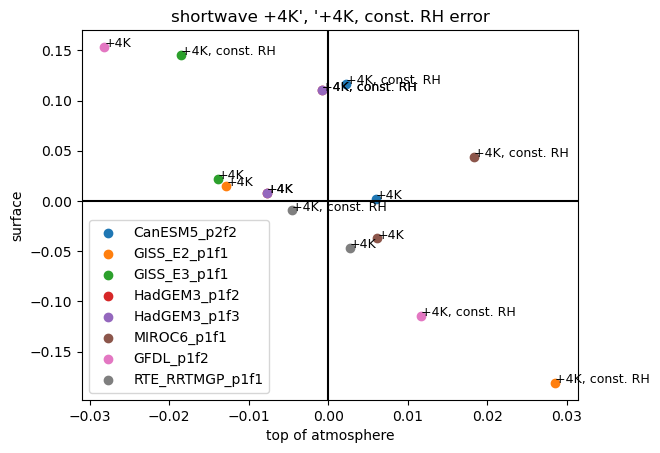

In [34]:
fig, ax = plt.subplots()
selected_experiments = ['+4K', '+4K, const. RH']

for m in list(gbme.keys()):
    if "RRTMG_p1f1" not in m:
        plt.scatter(gbme[m].data_vars["rsn"][:,0].sel(expt=['+4K', '+4K, const. RH']),gbme[m].data_vars["rsn"][:,60].sel(expt=['+4K', '+4K, const. RH']))
        for i in range(len(gbme[m].expt)):
            if gbme[m].expt[i].values in selected_experiments:
                plt.text(gbme[m].data_vars["rsn"][i,0],gbme[m].data_vars["rsn"][i,60], gbme[m].expt[i].values, fontsize=9)
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend([k for k in gbme.keys() if "RRTMG_p1f1" not in k])
plt.title("shortwave +4K', '+4K, const. RH error")
plt.show()